# EE5175 Lab 1 : Geometric Transforms
Author: Kishore Rajendran [EE20B064]

Date: 4 Feb 2024

In [9]:
# Importing required libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

Bilinear Interpolation

In [10]:
# Given the transformed source image pixel coordinates and the image, apply bilinear interpolation to return correct target intensity
def bilinear_interpolation(xs, ys, img):
    xs_i = np.floor(xs)
    ys_i = np.floor(ys)
    a = xs - xs_i
    b = ys - ys_i
    # If the transformed pixel value is out of bounds
    if xs_i < 0 or xs_i >= img.shape[0] - 1 or ys_i < 0 or ys_i >= img.shape[1] - 1:
        return 0
    else:
        # Converting to int, so that the co-ordinates can be used as array indices
        xs_i = int(xs_i)
        ys_i = int(ys_i)
        # Bilinear interpolation
        return (1-a)*(1-b)*img[xs_i, ys_i] + (1-a)*b*img[xs_i, ys_i+1] + a*(1-b)*img[xs_i+1, ys_i] + a*b*img[xs_i+1, ys_i+1]

Applying Target to Source Transformation

In [11]:
# Given the target image pixel coordinates and the transform, obtain the corresponding source image pixel coordinates and return new image
def transform_img(img, transform, *args):
    # Padding the image with zeros for applying interpolation at the edges of the image
    img = np.pad(img, ((1,1), (1,1)), mode='constant', constant_values=(0,0))
    # Creating an array of zeros which is our target image
    trf_img = np.zeros_like(img)
    # Translation (tx, ty)
    if transform == "translate":
        tx = args[0]
        ty = args[1]
        for xt in range(img.shape[0]):
            for yt in range(img.shape[1]):
                xs = xt - tx
                ys = yt - ty
                trf_img[xt, yt] = bilinear_interpolation(xs, ys, img)
    # Rotation about the center (theta) 
    elif transform == "rotate":
        theta = args[0]
        for xt in range(img.shape[0]):
            for yt in range(img.shape[1]):
                # Shifting origin to the center of the picture
                xt_shift = xt - img.shape[0]/2
                yt_shift = yt - img.shape[1]/2
                # Applying rotation, then shifting back
                xs = xt_shift*np.cos(theta) - yt_shift*np.sin(theta) + img.shape[0]/2
                ys = xt_shift*np.sin(theta) + yt_shift*np.cos(theta) + img.shape[1]/2
                trf_img[xt, yt] = bilinear_interpolation(xs, ys, img)
    # Non-uniform Scaling (a, b)
    elif transform =="scale":
        a = args[0]
        b = args[1]
        # Changing the shape of the target canvas to accomodate the scaling
        trf_img = np.zeros((int(img.shape[0]*a), int(img.shape[1]*b)))
        for xt in range(int(img.shape[0]*a)):
            for yt in range(int(img.shape[1]*b)):
                xs = xt/a
                ys = yt/b
                trf_img[xt, yt] = bilinear_interpolation(xs, ys, img)
    return trf_img


Q1: Translation

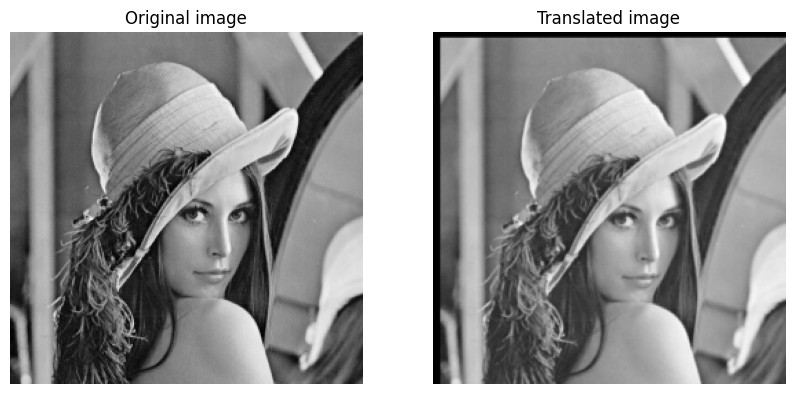

In [12]:
# Importing the image as a numpy array
img1 = np.array(Image.open("lena_translate.png"))

# Translation by tx, ty : Given parameters
tx = 3.75
ty = 4.3

# Obtaining the new translated image
trf_img1 = transform_img(img1, "translate", tx, ty)

# Plotting the 2 images side by side
fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(img1, cmap='gray')
ax[0].set_title("Original image")
ax[0].axis('off')

ax[1].imshow(trf_img1, cmap='gray')
ax[1].set_title("Translated image")
ax[1].axis('off')

plt.show()

Q2: Rotation

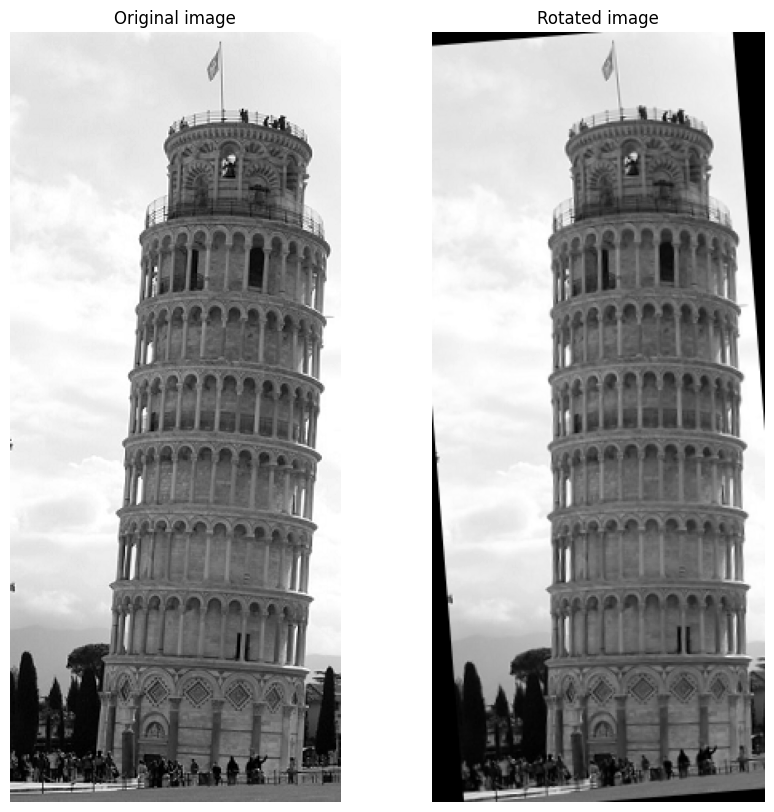

In [13]:
# Importing the image as a numpy array
img2 = np.array(Image.open("pisa_rotate.png"))

# Rotation by theta (Multiplying with pi/180 for degree to radian conversion)
theta = -4.6*(np.pi/180)

# Obtaining the new rotated image
trf_img2 = transform_img(img2, "rotate", theta)

# Plotting the 2 images side by side
fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(img2, cmap='gray')
ax[0].set_title("Original image")
ax[0].axis('off')

ax[1].imshow(trf_img2, cmap='gray')
ax[1].set_title("Rotated image")
ax[1].axis('off')

plt.show()

Q3: Scaling

Size of old image = (240, 315)
Size of scaled image = (193, 412)


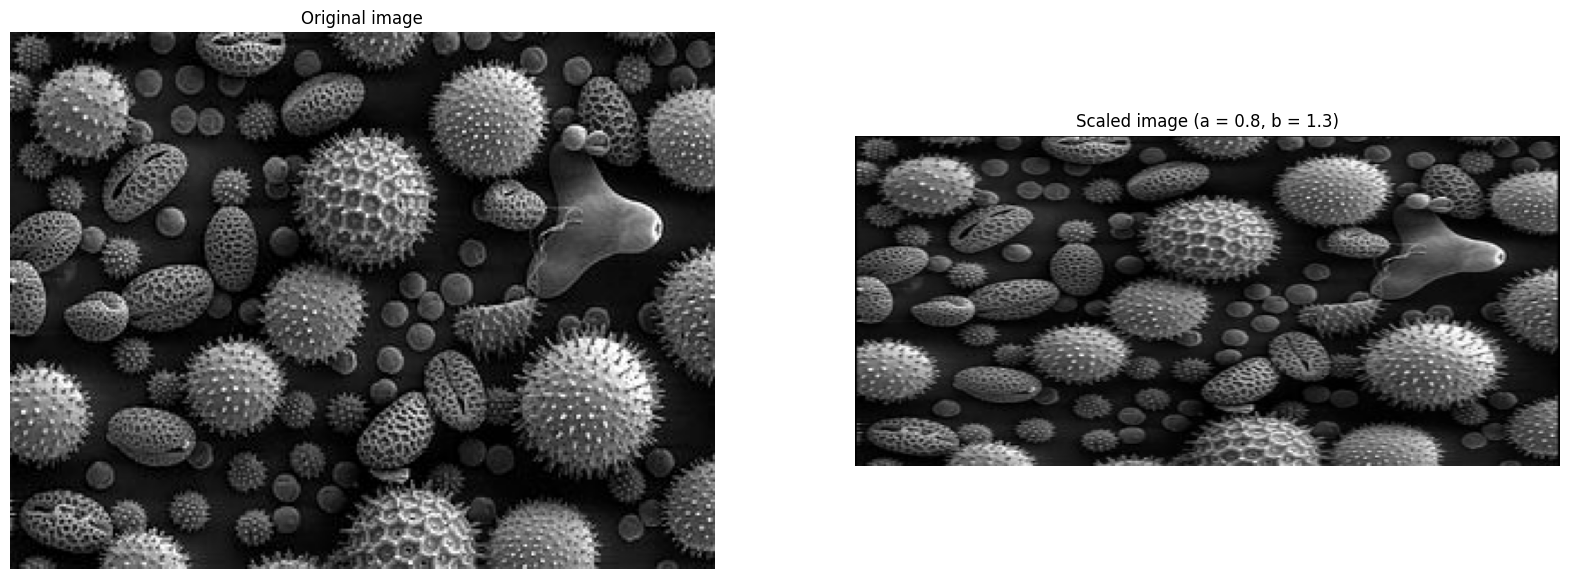

In [14]:
# Importing the image as a numpy array
img3 = np.array(Image.open("cells_scale.png"))

# Scaling by a = 0.8, b = 1.3
a = 0.8
b = 1.3
trf_img3 = transform_img(img3, "scale", a, b)
print("Size of old image =",img3.shape)
print("Size of scaled image =",trf_img3.shape)

# Plotting the 3 images side by side
fig, ax = plt.subplots(1, 2, figsize=(20,20))
ax[0].imshow(img3, cmap='gray')
ax[0].set_title("Original image")
ax[0].axis('off')

ax[1].imshow(trf_img3, cmap='gray')
ax[1].set_title("Scaled image (a = 0.8, b = 1.3)")
ax[1].axis('off')

plt.show()

# Observations
1. Translation
    1. Eventhough the tx and ty parameters are not integers, we are able to translate the image using interpolation.
    2. Since Bilinear Interpolation considers a weighted average of the 4 nearest neighbours, the translated image looks a bit more blurred than the original.

2. Rotation
    1. The edges of the image would look jagged if the input image wasn't padded before applying the transform and during interpolation, we would have just output zero for all the edge points which don't have all 4 nearest neighbours.
    2. We also output zero (ie. black pixels) when the target to source transformation gives a point which is out of bounds and doesn't exist in the source image, which is the reason for all the black space in the transformed image.
    3. In order to rotate about the center, before applying the target to source transformation, we shift the target co-ordinates such that the center of the target image becomes origin. After the transformation, the corresponding source coordinates xs, ys that we have obtained are also mapped according to the center of the source image being the origin. Since the co-ordinate system we follow has the top-left corner as origin, we must again shift back in order to assign the corrrect intensities.

3. Scaling
    1. The image scales about the origin of the image, which is the top-left corner according to the coordinate convention.
    2. As mentioned in the forum, a non-uniform scaling with a big enough target canvas has been implemented.

Note: Transformed images can be saved using: 
im = Image.fromarray(arr) and 
im.save("trf_img.png")
Since I'm using an ipynb file, I have simply displayed the images directly.